## Logistic Regression

#### Importing libraries

In [20]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from sklearn.metrics import classification_report, recall_score, precision_score, accuracy_score, f1_score
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

#### Importing Attrition CSV File and dropping null values

In [2]:
df = pd.read_csv("../WA_Fn-UseC_-HR-Employee-Attrition.csv")
df = df.dropna(axis='columns', how='all')
df = df.drop(columns = ['Over18', 'EmployeeNumber', 'StandardHours', 'EmployeeCount'])
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,3,Male,...,3,3,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,4,Male,...,3,1,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,2,Male,...,4,2,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,4,Male,...,3,4,0,17,3,2,9,6,0,8


#### Adding new variables

In [3]:
monthlyIncomeBins = [0,2000,4000,6000,8000,10000,20000]
monthlyIncomeLabels = [0,1,2,3,4,5]
df['MonthlyIncomeBins'] = pd.cut(df['MonthlyIncome'], bins=monthlyIncomeBins, labels=monthlyIncomeLabels)
df['PromotionRatio'] = df['YearsSinceLastPromotion']/df['YearsAtCompany']
df['PromotionRatio'] = df['PromotionRatio'].fillna(0)
df['PromotionRatio'] = df['PromotionRatio'].replace(np.inf,0)
df['ManagerRatio'] = df['YearsWithCurrManager']/df['YearsAtCompany']
df['ManagerRatio'] = df['ManagerRatio'].fillna(0)
df['ManagerRatio'] = df['ManagerRatio'].replace(np.inf,0)
df['CompanyRatio'] = df['YearsAtCompany']/df['TotalWorkingYears']
df['CompanyRatio'] = df['CompanyRatio'].fillna(0)
df['CompanyRatio'] = df['CompanyRatio'].replace(np.inf,0)
df['SpecificIncome'] = df['MonthlyIncome']/np.mean(df['MonthlyIncome'])
df['SpecificIncome'] = df['SpecificIncome'].fillna(0)
df['Role-Manager-Ratio'] = df['YearsInCurrentRole']/df['YearsWithCurrManager']
df['Role-Manager-Ratio'] = df['Role-Manager-Ratio'].fillna(0)
df['Role-Manager-Ratio'] = df['Role-Manager-Ratio'].replace(np.inf,0)
df['Yearspercompany']=(df['TotalWorkingYears']/df['NumCompaniesWorked']+1)
df['Yearspercompany'] = df['Yearspercompany'].fillna(0)
df['Yearspercompany'] = df['Yearspercompany'].replace(np.inf,0)
df['AverageTimePerCompany'] = (df['Age']-20) / ((df)['NumCompaniesWorked']+1)
df['SatisfactionAverage'] = (df['RelationshipSatisfaction']  + df['EnvironmentSatisfaction'] + df['JobSatisfaction'] + df['JobInvolvement'] + df['WorkLifeBalance'])/5
df['Fidelity'] = (df['NumCompaniesWorked']/df['TotalWorkingYears'])
df['Fidelity'] = df['Fidelity'].replace(np.Inf, 0)
df['Stability'] = df['YearsInCurrentRole'] / df['YearsAtCompany']
df['Stability'].fillna((df['Stability'].mean()), inplace=True)
df['RateRatio'] = df['HourlyRate'] / df['MonthlyRate']
def SalesDpt(df) :
    if df['Department'] == 'Sales':
        return 1
    else:
        return 0
df['SalesDpt'] = df.apply(lambda df:SalesDpt(df) ,axis = 1)
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'MonthlyIncomeBins',
       'PromotionRatio', 'ManagerRatio', 'CompanyRatio', 'SpecificIncome',
       'Role-Manager-Ratio', 'Yearspercompany', 'AverageTimePerCompany',
       'SatisfactionAverage', 'Fidelity', 'Stability', 'RateRatio',
       'SalesDpt'],
      dtype='object')

#### Creating a correlation matrix

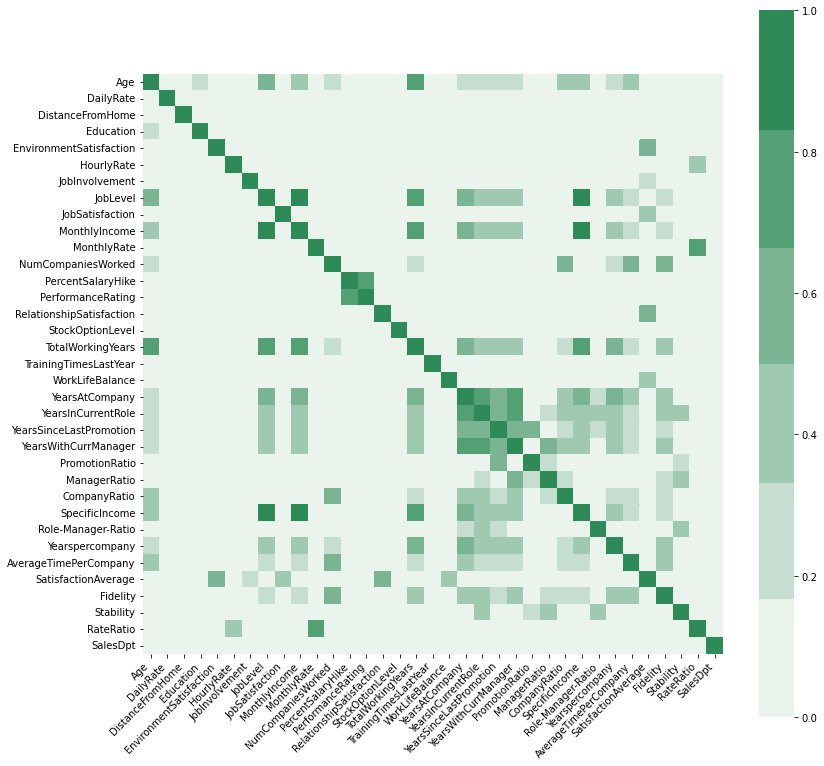

In [4]:
corr = df.corr().abs()
fig, ax = plt.subplots(figsize=(13,13))
ax = sns.heatmap(
    corr, 
    vmin=0, vmax=1, center=0.5,
    cmap=sns.light_palette("seagreen"),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

#### Dropping correlated columns

In [5]:
corrLimit = .5
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
dropColumns = [column for column in upper.columns if any(upper[column] > corrLimit)]

print('Columns to remove: %d' % (len(dropColumns)))
dropped = df.drop(columns = dropColumns)
dropColumns

Columns to remove: 17


['JobLevel',
 'MonthlyIncome',
 'PerformanceRating',
 'TotalWorkingYears',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'PromotionRatio',
 'ManagerRatio',
 'CompanyRatio',
 'SpecificIncome',
 'Yearspercompany',
 'AverageTimePerCompany',
 'SatisfactionAverage',
 'Fidelity',
 'RateRatio']

#### Creating X and y for Model (Dropped Features)

In [6]:
dropped = df.drop(columns = ["Attrition"])
data_binary_encoded = pd.get_dummies(dropped)
X=data_binary_encoded
y=df["Attrition"].replace({'Yes': 1, 'No': 0})
X.shape

(1470, 69)

#### Creating a Function that runs Logistic Regression Model and returns a list with:
[Train Score, Test Score, Precision Score, Accuracy Score, F1 Score, Recall Score, Classification Report]

In [7]:
def createModel(X):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
    X_scaler = MinMaxScaler().fit(X_train)
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    model = LogisticRegression()
    model = model.fit(X_train_scaled, y_train)
    trainScore = model.score(X_train_scaled,y_train)
    testScore = model.score(X_test_scaled,y_test)
    test = model.predict(X)
    precisionScore = precision_score(y,test)
    accuracyScore = accuracy_score(y,test)
    f1Score = f1_score(y,test)
    recallScore = recall_score(y,test)
    classRep = classification_report(y,test)
    retList = [trainScore, testScore, precisionScore, accuracyScore, f1Score, recallScore, classRep]
    return retList

modelResults = createModel(X)
print(f'\033[1m Train Score: \033[0;0m {round(modelResults[0],3)}')
print(f'\033[1m Test Score: \033[0;0m {round(modelResults[1],3)}')
print(f'\033[1m Precision Score: \033[0;0m {round(modelResults[2],3)}')
print(f'\033[1m Accuracy Score: \033[0;0m {round(modelResults[3],3)}')
print(f'\033[1m F1 Score: \033[0;0m {round(modelResults[4],3)}')
print(f'\033[1m Recall Score: \033[0;0m {round(modelResults[5],3)}')
print("\033[1m Classification Report: \033[0;0m")
print(modelResults[6])

 Train Score:  0.907
 Test Score:  0.883
 Precision Score:  0.179
 Accuracy Score:  0.411
 F1 Score:  0.288
 Recall Score:  0.738
 Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.35      0.50      1233
           1       0.18      0.74      0.29       237

    accuracy                           0.41      1470
   macro avg       0.53      0.54      0.39      1470
weighted avg       0.76      0.41      0.46      1470



Even though our initial model has over 88% Test and Train Scores, Precision Score was only 18% and Accuracy Score under 50%. The model is probably overtrained, to get the best results and lower the amount of variables needed BRUTE FORCE was applied.

#### Selecting Features

In [8]:
features = ['OverTime', 'Fidelity', 'MaritalStatus','Gender', 'Department', 'BusinessTravel', 'SalesDpt',
            'Age', 'Stability', 'RateRatio', 'AverageTimePerCompany', 'SatisfactionAverage', 'StockOptionLevel',
            'PerformanceRating', 'TrainingTimesLastYear', 'YearsWithCurrManager', 'DistanceFromHome', 'Education']

print("Total Features : "+str(len(features)))
features

Total Features : 18


['OverTime',
 'Fidelity',
 'MaritalStatus',
 'Gender',
 'Department',
 'BusinessTravel',
 'SalesDpt',
 'Age',
 'Stability',
 'RateRatio',
 'AverageTimePerCompany',
 'SatisfactionAverage',
 'StockOptionLevel',
 'PerformanceRating',
 'TrainingTimesLastYear',
 'YearsWithCurrManager',
 'DistanceFromHome',
 'Education']

In [9]:
testCombinations = []
for i in range(5, len(features)):
    testCombinations += list(combinations(features, i))

print(f'Total Combinations: {len(testCombinations)}')

Total Combinations: 258095


#### BRUTE FORCE

In [16]:
minCombinations = 5
newFeatures = []
for i in range(minCombinations, len(features)):
    newFeatures += list(combinations(features, i))

# Uncomment the next line to create a fast example
newFeatures = list(combinations(features, len(features)-1))
scores = []
counter = 1

for i in newFeatures:
    if (counter%(round(len(newFeatures)/20,0))==0):
        print(f'Progress {round(counter/len(newFeatures)*100,1)}% {counter}/{len(newFeatures)}')
    counter += 1
    newDF = df.filter(i, axis=1)
    X = pd.get_dummies(newDF)
    retList = createModel(X)
    retList.append(i)
    retList.append(len(i))
    scores.append(retList)

print("Models processing complete!")

Progress 5.6% 1/18
Progress 11.1% 2/18
Progress 16.7% 3/18
Progress 22.2% 4/18
Progress 27.8% 5/18
Progress 33.3% 6/18
Progress 38.9% 7/18
Progress 44.4% 8/18
Progress 50.0% 9/18
Progress 55.6% 10/18
Progress 61.1% 11/18
Progress 66.7% 12/18
Progress 72.2% 13/18
Progress 77.8% 14/18
Progress 83.3% 15/18
Progress 88.9% 16/18
Progress 94.4% 17/18
Progress 100.0% 18/18
Models processing complete!


#### Creating a Dataframe of Results sorted by F1Score

In [17]:
# Converting to Dataframe and Sorting
scoresDF = pd.DataFrame(scores)
scoresDF.columns = ["trainScore", "testScore", "precisionScore","accuracyScore", "f1Score","recallScore", "classificationReport", "Features", "featureCount"]
scoresDF = scoresDF.sort_values(["f1Score"], ascending=False)
scoresDF

,trainScore,testScore,precisionScore,accuracyScore,f1Score,recallScore,classificationReport,Features,featureCount
10,0.884755,0.839674,0.328125,0.793878,0.293706,0.265823,precision recall f1-score ...,"(OverTime, Fidelity, MaritalStatus, Gender, De...",17
6,0.877495,0.828804,0.500000,0.838776,0.008368,0.004219,precision recall f1-score ...,"(OverTime, Fidelity, MaritalStatus, Gender, De...",17
0,0.885662,0.850543,0.000000,0.838776,0.000000,0.000000,precision recall f1-score ...,"(OverTime, Fidelity, MaritalStatus, Gender, De...",17
16,0.880218,0.855978,0.000000,0.838776,0.000000,0.000000,precision recall f1-score ...,"(OverTime, MaritalStatus, Gender, Department, ...",17
15,0.885662,0.850543,0.000000,0.838776,0.000000,0.000000,precision recall f1-score ...,"(OverTime, Fidelity, Gender, Department, Busin...",17
14,0.879310,0.861413,0.000000,0.838776,0.000000,0.000000,precision recall f1-score ...,"(OverTime, Fidelity, MaritalStatus, Department...",17
13,0.887477,0.853261,0.000000,0.838776,0.000000,0.000000,precision recall f1-score ...,"(OverTime, Fidelity, MaritalStatus, Gender, Bu...",17
12,0.877495,0.858696,0.000000,0.838776,0.000000,0.000000,precision recall f1-score ...,"(OverTime, Fidelity, MaritalStatus, Gender, De...",17
11,0.887477,0.855978,0.000000,0.838776,0.000000,0.000000,precision recall f1-score ...,"(OverTime, Fidelity, MaritalStatus, Gender, De...",17
9,0.888385,0.855978,0.000000,0.838776,0.000000,0.000000,precision recall f1-score ...,"(OverTime, Fidelity, MaritalStatus, Gender, De...",17


#### Feature Importance on Filtered Models

OverTime 0
Fidelity 0
MaritalStatus 0
Gender 0
Department 0
BusinessTravel 0
SalesDpt 0
Age 0
Stability 0
RateRatio 0
AverageTimePerCompany 0
SatisfactionAverage 0
StockOptionLevel 0
PerformanceRating 0
TrainingTimesLastYear 0
YearsWithCurrManager 0
DistanceFromHome 0
Education 0


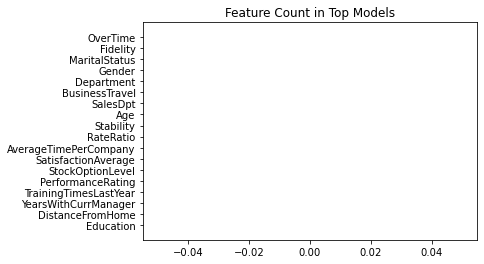

In [18]:
filterDF = scoresDF.loc[scoresDF["f1Score"]>.2] \
    .loc[scoresDF["precisionScore"]>.2] \
    .loc[scoresDF["accuracyScore"]>.6] \
    .loc[scoresDF["recallScore"]>.2] \
    .loc[scoresDF["featureCount"]<10]
filterDF['Features'] = filterDF['Features'].astype(str)
countDict = {} 
for feature in features:
    countDict[feature] = len(filterDF[filterDF['Features'].str.contains(feature)])

sortedDict = sorted(countDict.items(), key=lambda x: x[1], reverse=True)
xval = []
yval = []
for i in sortedDict:
    yval.append(i[0])
    xval.append(i[1]) 
    print(i[0], i[1])

fig, ax = plt.subplots()
ax.barh(yval, xval)
ax.set_yticks(yval)
ax.set_yticklabels(yval)
ax.invert_yaxis()
ax.set_title('Feature Count in Top Models')

plt.show()

#### Classification Reports on Best Models

In [19]:
print(len(scoresDF.loc[1][7]))
print(scoresDF.loc[1][6])
print(scoresDF.loc[2][7])
print(scoresDF.loc[2][6])
print(scoresDF.loc[3][7])
print(scoresDF.loc[3][6])


17
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1233
           1       0.00      0.00      0.00       237

    accuracy                           0.84      1470
   macro avg       0.42      0.50      0.46      1470
weighted avg       0.70      0.84      0.77      1470

('OverTime', 'Fidelity', 'MaritalStatus', 'Gender', 'Department', 'BusinessTravel', 'SalesDpt', 'Age', 'Stability', 'RateRatio', 'AverageTimePerCompany', 'SatisfactionAverage', 'StockOptionLevel', 'PerformanceRating', 'TrainingTimesLastYear', 'DistanceFromHome', 'Education')
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1233
           1       0.00      0.00      0.00       237

    accuracy                           0.84      1470
   macro avg       0.42      0.50      0.46      1470
weighted avg       0.70      0.84      0.77      1470

('OverTime', 'Fidelity', 'MaritalStatus', 'Gender', 'Department', '

In [14]:
#scoresDF.to_csv('scoresDF7.csv', index=False, header=True)

In [ ]:
os.system('jupyter nbconvert --to html yourNotebook.ipynb')